<a href="https://colab.research.google.com/github/simulate111/mini-project-2-Abo/blob/main/Alaina%20Faisal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import string
import re
import pickle
import csv

import tensorflow as tf
from nltk.corpus import stopwords
import keras.backend as K
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input,Embedding,Dropout,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization,SimpleRNN,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
#import transformers
#import tokenizers

from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import pipeline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

#plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Dataset
The dataset being used is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

It contains the following 6 fields:

*  sentiment: the polarity of the tweet (0 = negative, 4 = positive)
*  ids: The id of the tweet (2087)
*  date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
*  flag: The query (lyx). If there is no query, then this value is NO_QUERY.
*  user: the user that tweeted (robotickilldozr)
*  text: the text of the tweet (Lyx is cool)
We require only the sentiment and text fields, so we discard the rest.

Furthermore, we're changing the sentiment field so that it has new values to reflect the sentiment. (0 = Negative, 1 = Positive)

In [3]:
# Data could be downloaded and imported from https://www.kaggle.com/datasets/ferno2/training1600000processednoemoticoncsv

In [4]:
!pip install kaggle

In [5]:
!pip install requests

In [6]:
#from google.colab import files
#uploaded = files.upload()

In [7]:
import requests
import json
import os

url = "https://raw.githubusercontent.com/simulate111/mini-project-2-Abo/main/kaggle.json"

response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the JSON content
    kaggle_config = response.json()

    # Save the Kaggle API key to a file
    with open('/content/kaggle.json', 'w') as file:
        json.dump(kaggle_config, file)

    # Set the Kaggle API key environment variable
    os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

    # Download the dataset and automatically accept the terms
    !kaggle datasets download -d ferno2/training1600000processednoemoticoncsv -p /content --force

    # Unzip the downloaded file without prompting for confirmation
    !unzip -q -o /content/training1600000processednoemoticoncsv.zip -d /content/dataset

    # Check the contents of the dataset folder
    !ls /content/dataset
else:
    print(f"Failed to fetch Kaggle API key. Status code: {response.status_code}")


 77% 62.0M/80.9M [00:00<00:00, 193MB/s]
100% 80.9M/80.9M [00:00<00:00, 183MB/s]
training.1600000.processed.noemoticon.csv


In [8]:
df=pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
df.columns=['sentiment', 'id', 'date', 'query', 'user_id', 'text']

In [10]:
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
print('length of data is', len(df))


length of data is 1600000


#Preprocessing

<Figure size 1200x600 with 0 Axes>

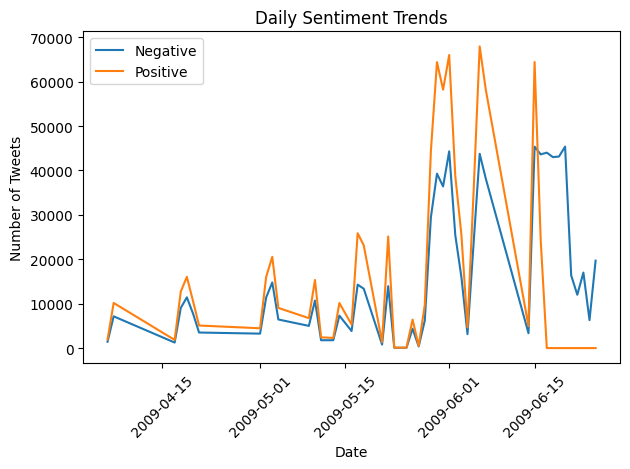

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the Sentiment140 dataset

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%a %b %d %H:%M:%S PDT %Y')

# Extract just the date part (optional, if you want to aggregate by day regardless of time)
df['just_date'] = df['date'].dt.date

# Map numerical sentiment to categorical for better readability
df['sentiment_category'] = df['sentiment'].map({0: 'Negative', 4: 'Positive'})

# Group by the new 'just_date' column and sentiment category, then count occurrences
daily_sentiments = df.groupby(['just_date', 'sentiment_category']).size().unstack().fillna(0)

# Plot
plt.figure(figsize=(12, 6))
daily_sentiments.plot(kind='line')
plt.title('Daily Sentiment Trends')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend(['Negative', 'Positive'])
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   sentiment           1600000 non-null  int64         
 1   id                  1600000 non-null  int64         
 2   date                1600000 non-null  datetime64[ns]
 3   query               1600000 non-null  object        
 4   user_id             1600000 non-null  object        
 5   text                1600000 non-null  object        
 6   just_date           1600000 non-null  object        
 7   sentiment_category  1600000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 97.7+ MB


In [14]:
Count = df.sentiment.value_counts()
Count

0    800000
4    800000
Name: sentiment, dtype: int64

In [15]:
df['sentiment'] = df['sentiment'].replace(4,1)
df=df[['text','sentiment']]
df.sentiment.value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

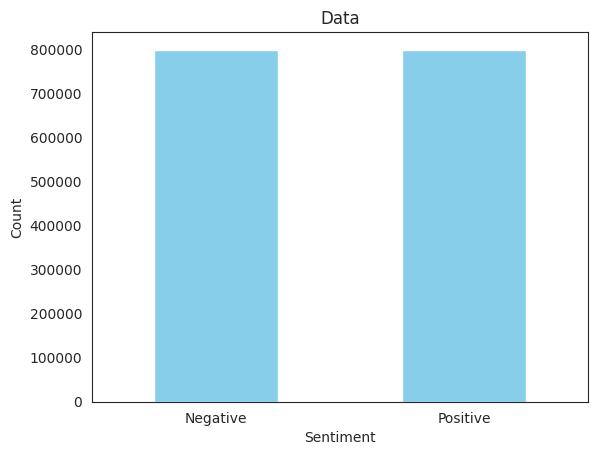

In [16]:
sns.set_style('white')
plot = df.groupby('sentiment').count().plot(kind='bar', title='Data',
                                          legend=False, color=['skyblue', 'salmon'], edgecolor=None)

plot.set_xticklabels(['Negative', 'Positive'], rotation=0)
plot.set_ylabel('Count')
plot.set_xlabel('Sentiment')

text, sentiment = list(df['text']), list(df['sentiment'])
plt.show()

In [17]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
STOPWORDS = set(stopwordlist)
# def cleaning_stopwords(text):
#     return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# def clean_text(s):
#     s = re.sub(r'http\S+', '', s)
#     s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
#     s = re.sub(r'@\S+', '', s)
#     s = re.sub('&amp', ' ', s)
#     return s

# df['text'] = df['text'].apply(lambda text: cleaning_stopwords(text))
# df['text'].head()
# df['text'] = df['text'].apply(clean_text)

In [18]:
def preprocess_data(text):
    processed = []
    wordLemm = WordNetLemmatizer()

    url      = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user       = '@[^\s]+'
    alpha     = "[^a-zA-Z0-9]"
    sequence = r"(.)\1\1+"
    seqReplace = r"\1\1"

    for t in text:
        t = t.lower()

        t = re.sub(url,' URL',t)
        for emoji in emojis.keys():
            t = t.replace(emoji, "EMOJI" + emojis[emoji])
        t = re.sub(user,' USER', t)
        t = re.sub(alpha, " ", t)
        t = re.sub(sequence, seqReplace, t)

        tw = ''
        for word in t.split():
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                tw += (word+' ')

        processed.append(tw)

    return processed

In [19]:
processedtext = preprocess_data(text)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)


In [21]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [22]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [23]:
SVC = LinearSVC()
history1=SVC.fit(X_train, y_train)

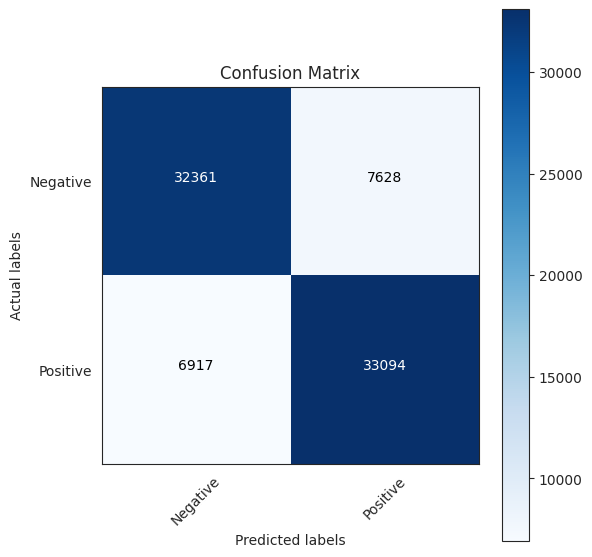

In [24]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
y_pred = SVC.predict(X_test)

# Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the simple confusion matrix
plt.figure(figsize=(6,6))
plt.imshow(cf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
tick_marks = np.arange(len(set(y_test))) # Assuming your labels are 0 and 1
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.colorbar()
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        plt.text(j, i, format(cf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cf_matrix[i, j] > cf_matrix.max() / 2. else "black")

plt.tight_layout()



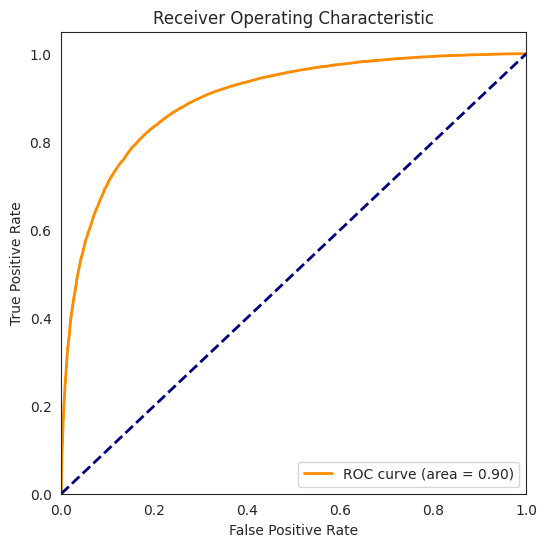

In [25]:

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, SVC.decision_function(X_test))
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [26]:
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


              precision    recall  f1-score   support

    Negative       0.82      0.81      0.82     39989
    Positive       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



#Bernouli NB

In [27]:
BNB = BernoulliNB(alpha = 2)
history2=BNB.fit(X_train, y_train)

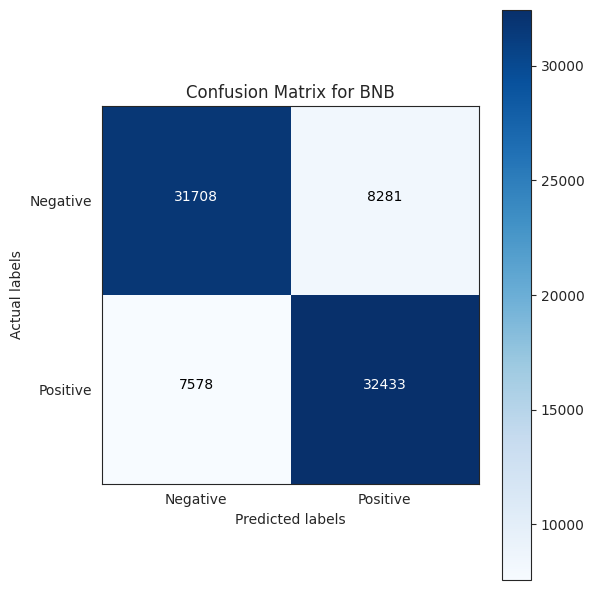

In [28]:
y_pred = BNB.predict(X_test)

# Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the simple confusion matrix
plt.figure(figsize=(6,6))
plt.imshow(cf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for BNB')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
tick_marks = np.arange(len(set(y_test))) # Assuming your labels are 0 and 1
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=0)
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.colorbar()
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        plt.text(j, i, format(cf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cf_matrix[i, j] > cf_matrix.max() / 2. else "black")

plt.tight_layout()



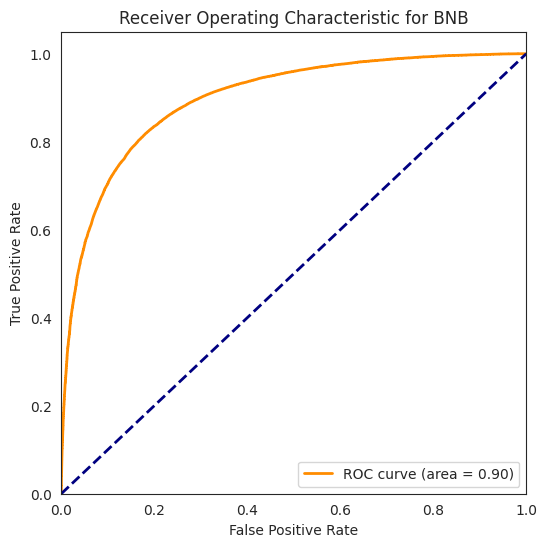

In [29]:

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, SVC.decision_function(X_test))
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for BNB')
plt.legend(loc="lower right")
plt.show()


In [30]:
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


              precision    recall  f1-score   support

    Negative       0.81      0.79      0.80     39989
    Positive       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



# Logistic Regression

In [31]:
LR = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
history3= LR.fit(X_train, y_train)

              precision    recall  f1-score   support

    Negative       0.83      0.82      0.83     39989
    Positive       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



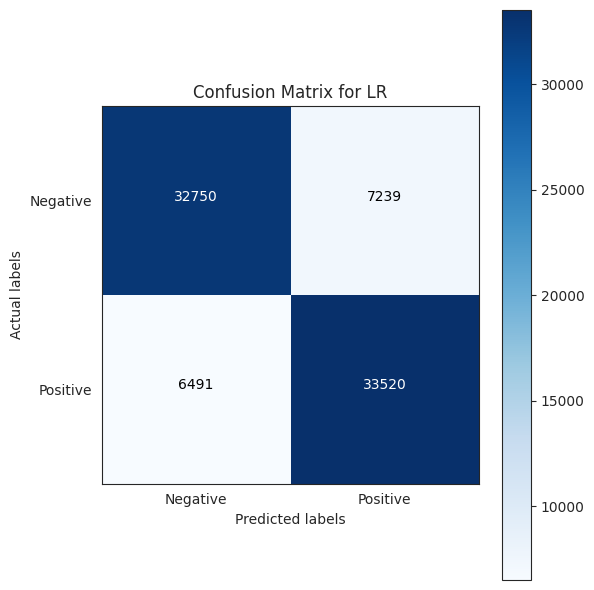

In [32]:
y_pred = LR.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
# Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the simple confusion matrix
plt.figure(figsize=(6,6))
plt.imshow(cf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for LR')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
tick_marks = np.arange(len(set(y_test))) # Assuming your labels are 0 and 1
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=0)
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.colorbar()
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        plt.text(j, i, format(cf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cf_matrix[i, j] > cf_matrix.max() / 2. else "black")

plt.tight_layout()


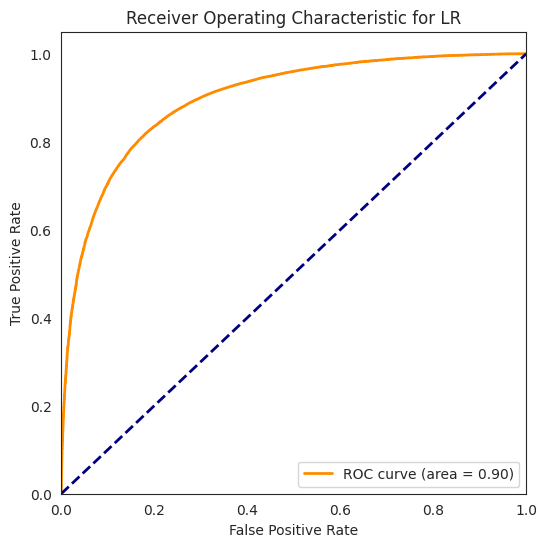

In [33]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, SVC.decision_function(X_test))
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LR')
plt.legend(loc="lower right")
plt.show()

# Preprocessing for CNN-LSTM Model

In [34]:
#Train test split
x=df.text
y=df.sentiment

X_train, X_test, y_train, y_test = train_test_split(x, y,
    test_size=0.05, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
    test_size=0.1, random_state= 8)

In [35]:
#tokenize
max_features = 40000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [36]:
#sequencing for lstm
max_words = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_words, padding = 'post')
X_val = sequence.pad_sequences(X_val, maxlen=max_words, padding = 'post')
X_test = sequence.pad_sequences(X_test, maxlen=max_words, padding = 'post')

In [37]:
#Evaluating proper format and shape
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
print(X_train.shape,X_val.shape, X_test.shape)

(1368000, 100) (152000, 100) (80000, 100)


# CNN Model

In [38]:
model = Sequential()
model.add(Embedding(40000, 10, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 10)           400000    
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           992       
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 25, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 32)            3

In [39]:
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10, batch_size=256, verbose=1)

Epoch 1/10
5344/5344 [==============================] - 190s 34ms/step - loss: 0.4295 - accuracy: 0.7963 - val_loss: 0.3966 - val_accuracy: 0.8192
Epoch 2/10
5344/5344 [==============================] - 125s 23ms/step - loss: 0.3751 - accuracy: 0.8324 - val_loss: 0.3879 - val_accuracy: 0.8247
Epoch 3/10
5344/5344 [==============================] - 120s 22ms/step - loss: 0.3551 - accuracy: 0.8428 - val_loss: 0.3893 - val_accuracy: 0.8249
Epoch 4/10
5344/5344 [==============================] - 124s 23ms/step - loss: 0.3405 - accuracy: 0.8502 - val_loss: 0.3963 - val_accuracy: 0.8232
Epoch 5/10
5344/5344 [==============================] - 118s 22ms/step - loss: 0.3286 - accuracy: 0.8560 - val_loss: 0.4114 - val_accuracy: 0.8221
Epoch 6/10
5344/5344 [==============================] - 120s 22ms/step - loss: 0.3188 - accuracy: 0.8609 - val_loss: 0.4148 - val_accuracy: 0.8207
Epoch 7/10
5344/5344 [==============================] - 122s 23ms/step - loss: 0.3099 - accuracy: 0.8656 - val_loss: 0

In [40]:
result = model.evaluate(X_test,y_test)
result

2500/2500 [==============================] - 11s 4ms/step - loss: 0.4477 - accuracy: 0.8134


[0.447736918926239, 0.8134499788284302]

In [41]:
!pip install matplotlib seaborn scikit-learn wordcloud

2500/2500 [==============================] - 14s 5ms/step


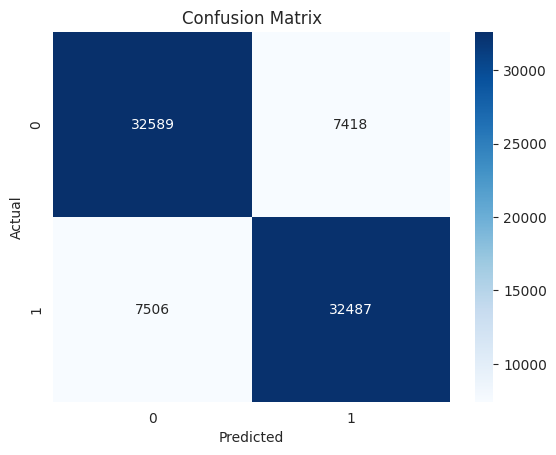

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming y_test contains true labels and y_pred contains predicted labels
y_pred = model.predict(X_test)  # Adjust this line according to your model's prediction method
y_pred_classes = np.argmax(y_pred, axis=1) if y_pred.shape[-1] > 1 else (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


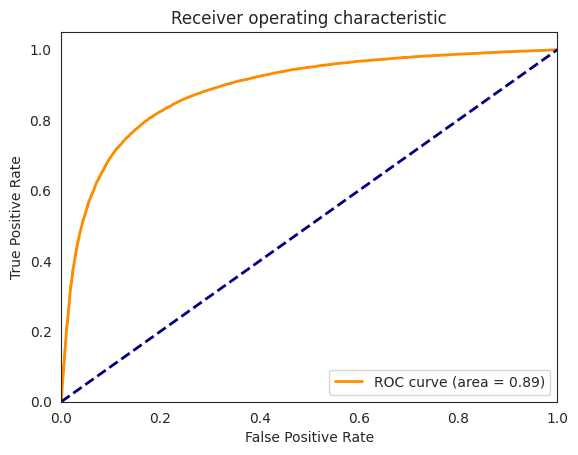

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


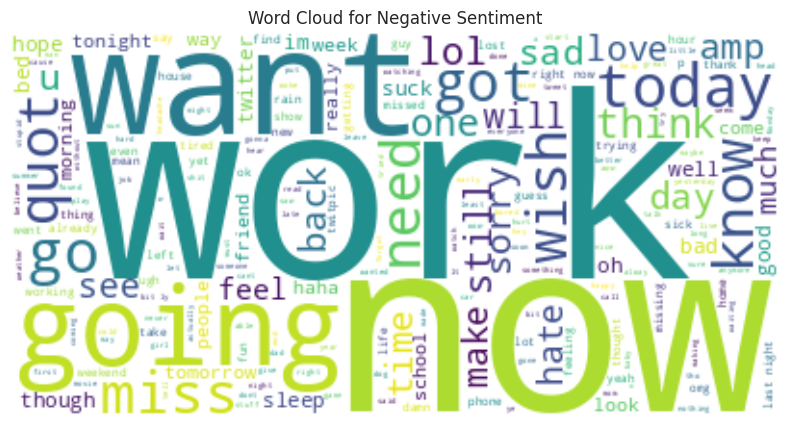

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text data with positive sentiment
positive_text = " ".join(text for text in df[df.sentiment == 0].text)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(positive_text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Negative Sentiment')
plt.show()

# Repeat the process for negative sentiment by filtering `data[data.sentiment == "negative"].text`


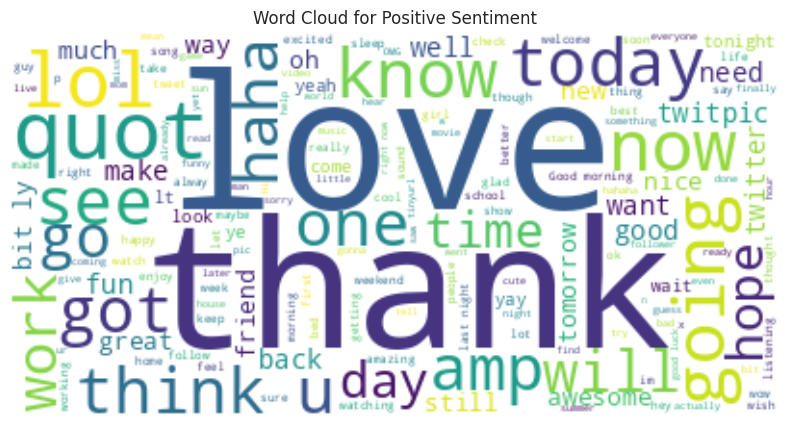

In [45]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text data with positive sentiment
positive_text = " ".join(text for text in df[df.sentiment == 1].text)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(positive_text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Positive Sentiment')
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     40007
           1       0.81      0.81      0.81     39993

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000



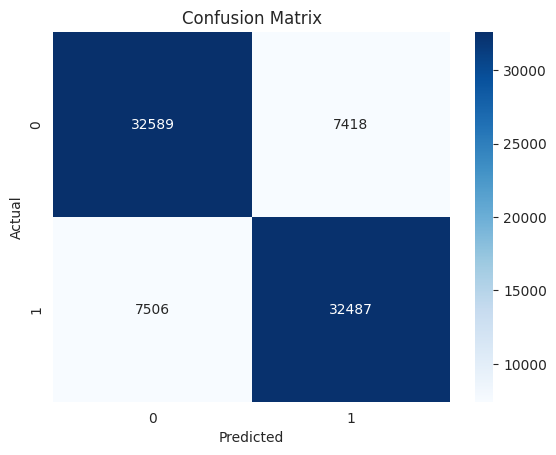

In [46]:
from sklearn.metrics import classification_report

# Assuming y_test contains true labels and y_pred_classes contains predicted labels
# You already have y_pred_classes from your previous code

# Generate the classification report
report = classification_report(y_test, y_pred_classes)

print("Classification Report:")
print(report)

# Your existing code for confusion matrix visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming y_test contains true labels and y_pred contains predicted labels
# You have y_pred and y_pred_classes from earlier in your code

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
